In [16]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import time
import concurrent.futures

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn.config import Config

# import imgaug
# from imgaug import augmenters as iaa
# import cv2


import skimage
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Root directory of the project
ROOT_DIR = '/home/sky8/cal/data/ddsm-mass/'

img_train = os.path.join(ROOT_DIR, 'train', 'images') 
img_val = os.path.join(ROOT_DIR, 'validation', 'images') 

mask_train = os.path.join(ROOT_DIR, 'train', 'masks') 
mask_val = os.path.join(ROOT_DIR, 'validation', 'masks') 


train_imglist = os.listdir(img_train)
val_imglist = os.listdir(img_val)

train_count = len(train_imglist)
val_count = len(val_imglist)
# width = 1280
# height = 800
# Directory to save logs and trained model
MODEL_DIR = os.path.join("/home/sky8/project/sky8/cal/", "logs")

# Local path to trained weights file
COCO_MODEL_PATH =  '/home/sky8/cal/code/model/mask_rcnn_coco.h5'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
len(train_imglist)

935

In [2]:
class CalConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "mass"

    # NUMBER OF GPUs to use. For CPU training, use 1
    GPU_COUNT = 1
    
    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = train_count// IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, val_count // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet101"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.1

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400
    
config = CalConfig()
config.display()   
 



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               200
MEAN_PIXEL                     [43.53 39.56 48.22]
MINI_MASK_SHAPE                (56, 56)
NAME                           mass
NUM_CLASSES                    3
POOL_SIZE                      7
POST_NMS_R

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
np.ones(5, dtype=np.int32)*2

array([2, 2, 2, 2, 2], dtype=int32)

In [5]:
class CalDataset(utils.Dataset):
    """Create customized dataset class to load data"""
    def load_cal(self,count, data_dir, mask_dir, namelist):
        """load """
        
        #Add classes
        self.add_class("breast", 1, "calcification" )
        self.add_class("breast", 2, "mass")
        
        #Add images
        
        for i in range(count):
            src = namelist[i]
            name = src.split('_')
            full_name = '_'.join(name[0:4])
            mask_path= os.path.join(mask_dir,full_name.split('.')[0])

            self.add_image("breast", image_id = i, path = os.path.join(data_dir, full_name), mask_path = mask_path , full_name =full_name)

            



    def load_mask(self, image_id):
        """load the mask image"""
        info = self.image_info[image_id]
        mask_path = info['mask_path']
        mask = []
        for i in range(10):
            full_mask_path = mask_path + '_' +str(i) +'.jpg'
        
            if os.path.exists(full_mask_path):
       
                m = skimage.io.imread(full_mask_path).astype(bool)
                mask.append(m)
            else:
                continue
        mask = np.stack(mask, axis=-1)
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index("mass")],dtype=np.int32)
        
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)* 2
        
    def load_name(self, image_id):
        """load the image name"""
        info = self.image_info[image_id]
        
        return info['full_name']
        

In [6]:
# Training dataset
dataset_train = CalDataset()
dataset_train.load_cal(train_count, img_train, mask_train, train_imglist)
dataset_train.prepare()

# Validation dataset
dataset_val = CalDataset()
dataset_val.load_cal(val_count, img_val, mask_val, val_imglist)
dataset_val.prepare()

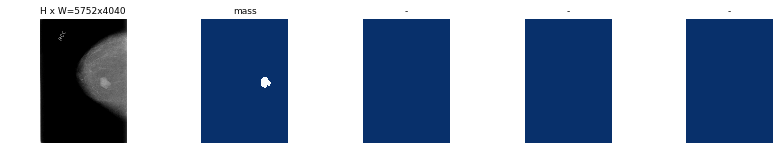

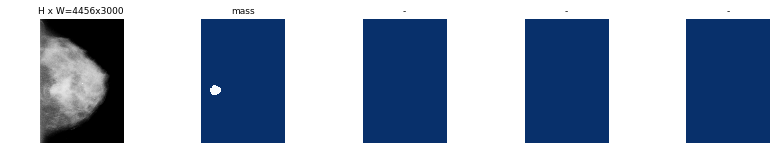

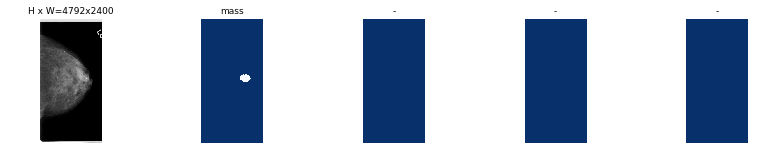

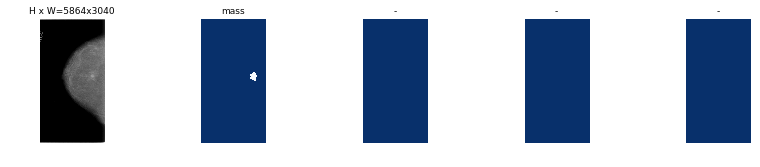

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    
        
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) 

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11966274783321988395
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11850914202
locality {
  bus_id: 1
}
incarnation: 10992034985819423689
physical_device_desc: "device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0"
]


In [9]:
!nvidia-smi

Thu May  3 07:50:52 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   35C    P0    31W / 250W |  11599MiB / 12193MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [16]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [19]:
# Load the last model you trained and continue training

model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
# model_path = model.find_last()[1]
# Load trained weights (fill in path to trained weights here)
# assert model_path != "", "Provide path to trained weights"

# print("Loading weights from ", model_path)
# model.load_weights(model_path, by_name=True)


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/sky8/cal/data/ddsm-mass/logs/calcification20180502T0152/mask_rcnn_calcification_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeD

/home/sky8/calcification/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sky8/calcification/lib/python3.5/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/2
466/467 [============================>.] - ETA: 3s - loss: 1.1488 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.5001 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.3232 - mrcnn_mask_loss: 0.2619

/home/sky8/calcification/lib/python3.5/site-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


467/467 [==============================] - 2374s 5s/step - loss: 1.1496 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.4998 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.3235 - mrcnn_mask_loss: 0.2627 - val_loss: 1.0133 - val_rpn_class_loss: 0.0339 - val_rpn_bbox_loss: 0.3599 - val_mrcnn_class_loss: 0.0043 - val_mrcnn_bbox_loss: 0.3421 - val_mrcnn_mask_loss: 0.2731
Epoch 2/2
 53/467 [==>...........................] - ETA: 24:09 - loss: 0.8534 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.3264 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.2363 - mrcnn_mask_loss: 0.2499

In [11]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=4, 
            layers="all")


Starting at epoch 2. LR=0.0002

Checkpoint Path: /home/sky8/cal/logs/cal20180418T0238/mask_rcnn_cal_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b         

/home/sky8/calcification/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sky8/calcification/lib/python3.5/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 3/4
 99/100 [============================>.] - ETA: 3s - loss: 5.1318 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 4.1992 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.5954 - mrcnn_mask_loss: 0.2063

/home/sky8/calcification/lib/python3.5/site-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 486s 5s/step - loss: 5.1256 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 4.1810 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.6026 - mrcnn_mask_loss: 0.2115 - val_loss: 3.9852 - val_rpn_class_loss: 0.0677 - val_rpn_bbox_loss: 2.8622 - val_mrcnn_class_loss: 0.0376 - val_mrcnn_bbox_loss: 0.6053 - val_mrcnn_mask_loss: 0.4124
Epoch 4/4
100/100 [==============================] - 267s 3s/step - loss: 3.2382 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 2.5384 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.2165 - val_loss: 3.5040 - val_rpn_class_loss: 0.0632 - val_rpn_bbox_loss: 2.9003 - val_mrcnn_class_loss: 0.0629 - val_mrcnn_bbox_loss: 0.3297 - val_mrcnn_mask_loss: 0.1479


## Detection

In [70]:
class InferenceConfig(CalConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "square"
    RPN_NMS_THRESHOLD = 0
    DETECTION_MIN_CONFIDENCE = 0.8
    BACKBONE = "resnet101"
    
inference_config = InferenceConfig()

DEVICE = "/gpu:0" 

In [71]:
# Recreate the model in inference mode
with tf.device(DEVICE):
    
    model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

mode = "last"

if mode == "coco":
    model_path = "/home/sky8/project/sky8/cal/logs/calcification-coco20180425T2351/mask_rcnn_calcification-coco_0080.h5"
    
elif mode == "imagenet-resnet50":
    model_path = "/home/sky8/cal/logs/calcification-resnet5020180419T0309/mask_rcnn_calcification-resnet50_0040.h5"
    
elif mode == "imagenet-resnet101":
    model_path = "/home/sky8/cal/code/resnet101_weights_tf.h5"

elif mode == "scrach":
    model_path = "/home/sky8/project/sky8/cal/logs/calcification20180419T0048/mask_rcnn_calcification_0120.h5"
# 
elif mode == "last":
    model_path = model.find_last()[1]


# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)

if mode == "coco":
    model.load_weights(model_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
else:
    
    model.load_weights(model_path, by_name=True)



Loading weights from  /home/sky8/project/sky8/cal/logs/mass20180502T0132/mask_rcnn_mass_0181.h5


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 5888.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  183.00000  max:  309.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


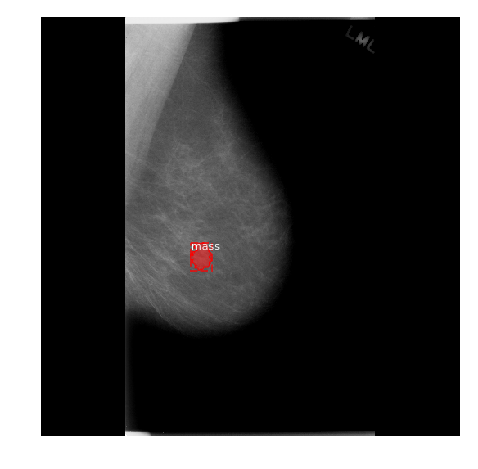

P_01604_LEFT_MLO.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 5491.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  135.00000  max:  358.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


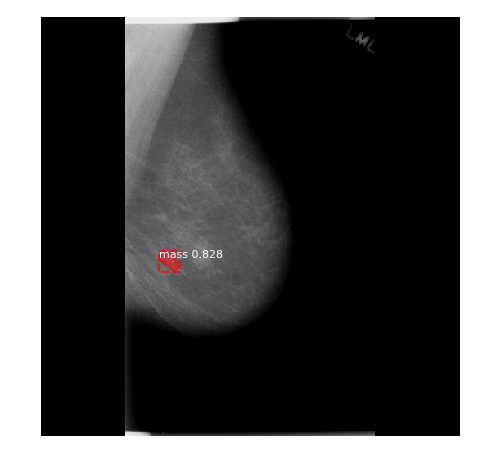

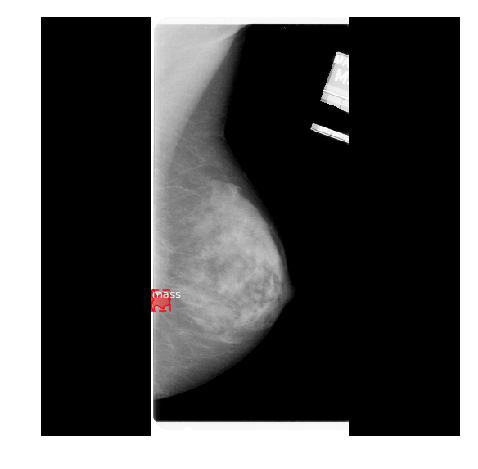

P_01557_RIGHT_MLO.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32

*** No instances to display *** 

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 6076.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  264.00000  max:  362.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


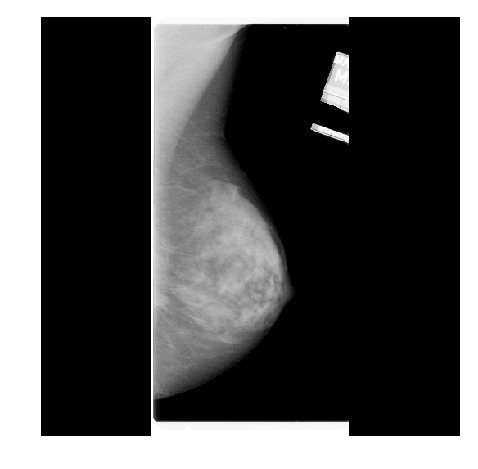

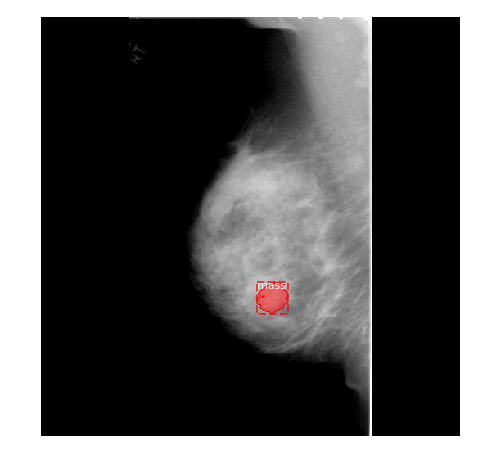

P_01613_LEFT_MLO.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 4996.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  243.00000  max:  312.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


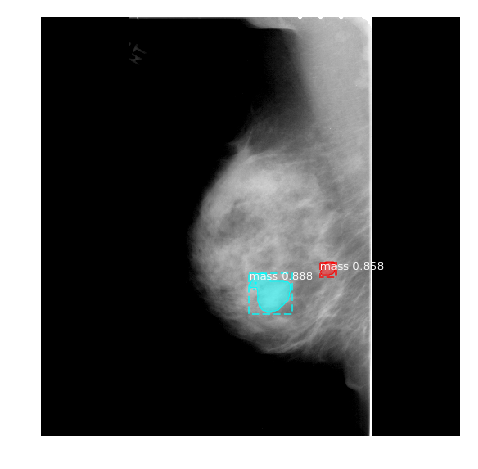

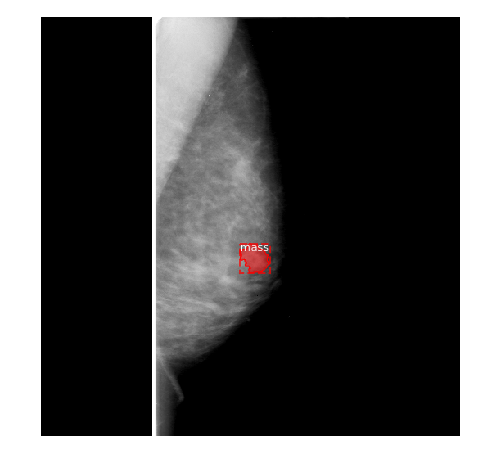

P_01876_LEFT_MLO.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 4616.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  303.00000  max:  337.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


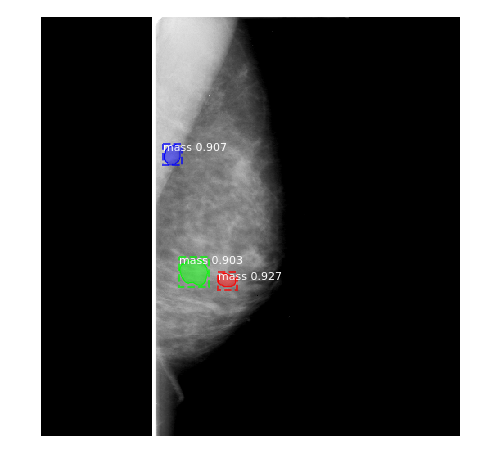

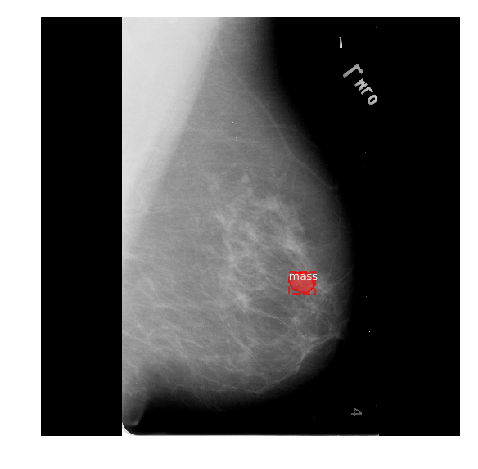

P_01890_LEFT_MLO.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 6691.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  255.00000  max:  346.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


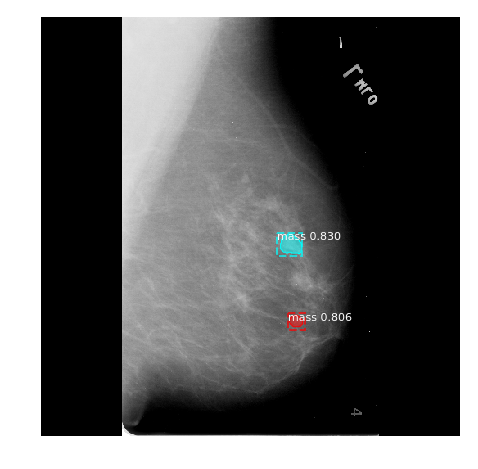

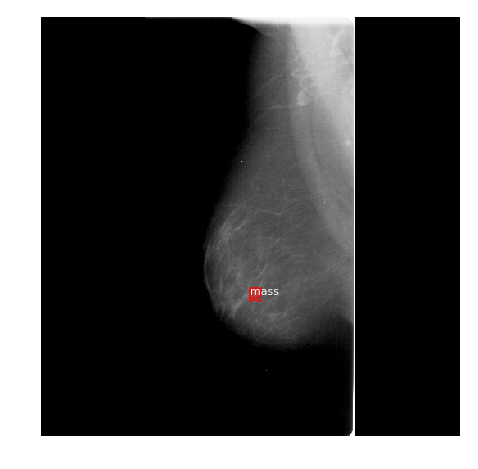

P_01581_LEFT_MLO.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32

*** No instances to display *** 

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 5920.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  209.00000  max:  348.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


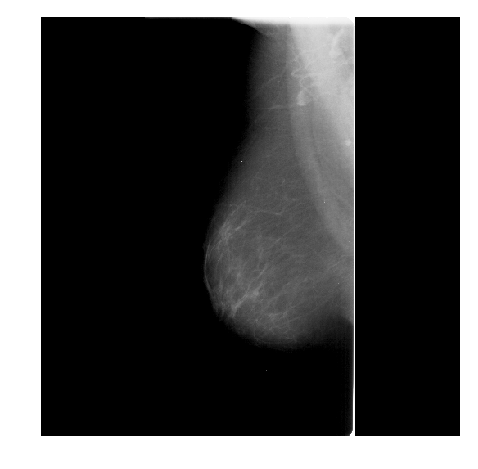

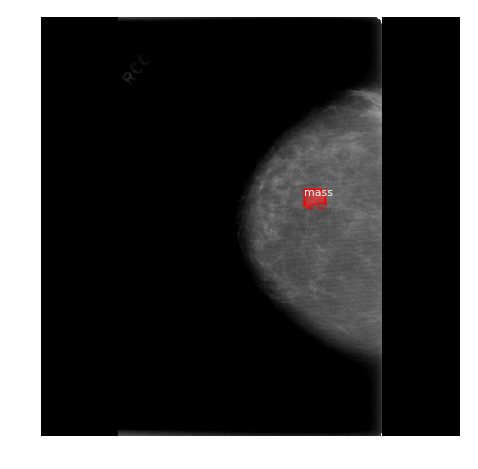

P_01889_RIGHT_CC.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
original_image           shape: (512, 512, 3)         min:    0.00000  max:  238.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 5824.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  140.00000  max:  330.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


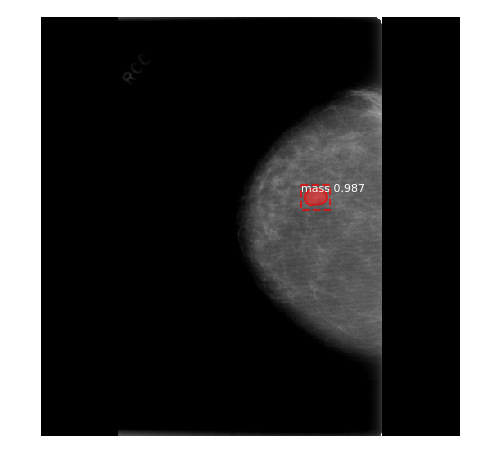

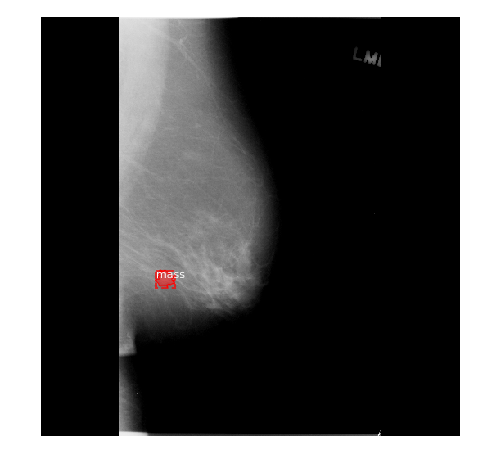

P_01761_LEFT_MLO.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  238.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  198.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 5806.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  238.00000  max:  309.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


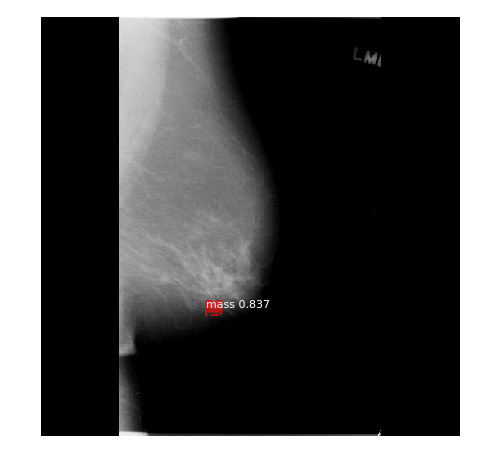

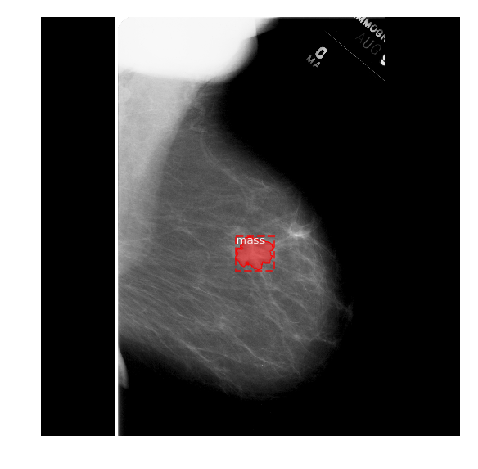

P_01559_RIGHT_MLO.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 5491.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  166.00000  max:  285.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


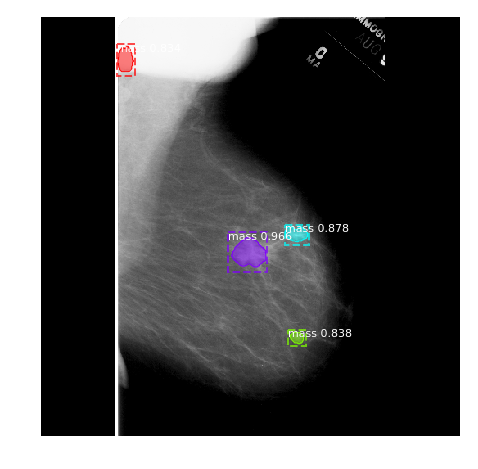

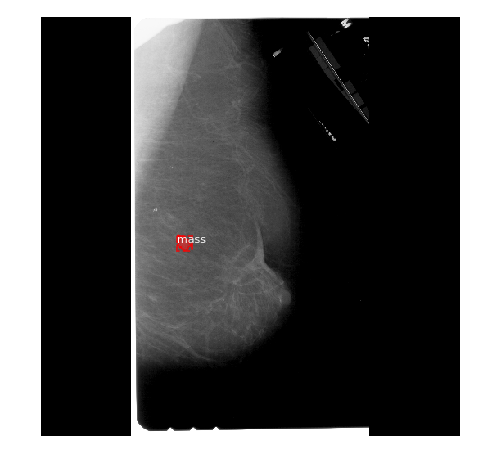

P_01611_RIGHT_MLO.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32

*** No instances to display *** 



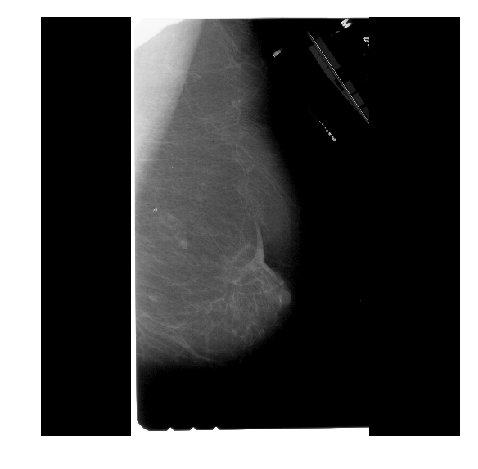

In [74]:
# Test on a random image
image_ids = np.random.choice(dataset_train.image_ids, 10)

for image_id in image_ids:
    image_id = random.choice(dataset_val.image_ids)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)

    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    output = visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_train.class_names, figsize=(8, 8))
    print(dataset_val.load_name(image_id))

    results = model.detect([original_image], verbose=1)
    r = results[0]

    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax())

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


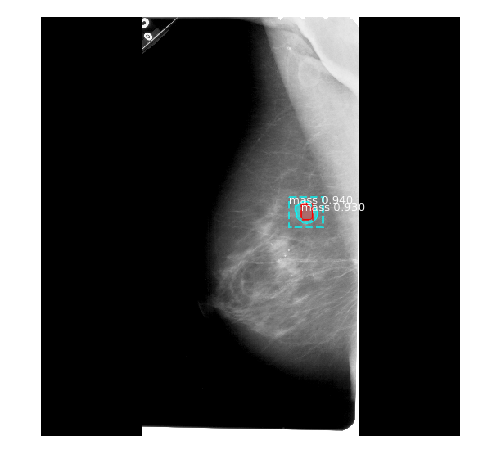

In [59]:
results = model.detect([original_image], verbose=1)
r = results[0]

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
test

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 4640.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  201.00000  max:  374.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


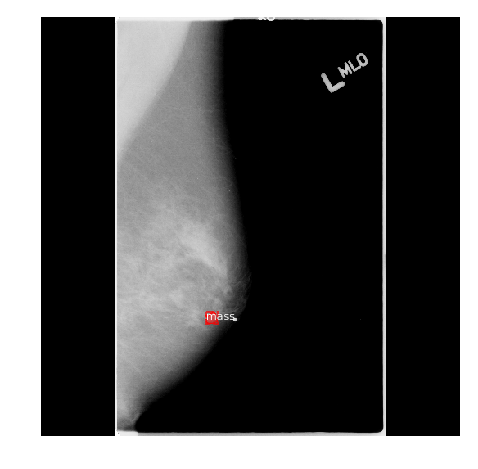

'P_01047_LEFT_MLO.jpg'

In [85]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

output = visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))
# skimage.io.imsave('/data1/share/shiky/Mask_RCNN/test2.jpg', output)
# # 	plt.savefig("/data1/share/shiky/Mask_RCNN/test.jpg")
# # print(output)
# mask, class_ids = dataset_val.load_mask(image_id)


# mask = mask.astype('uint8')


# mask[mask == 1] = 255
# mask = mask[:, :, 0]
# # cv2.imshow('mask',mask)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# plt.figure(figsize=(13,13))
# plt.imshow(mask, cmap='gray')
dataset_train.load_name(image_id)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


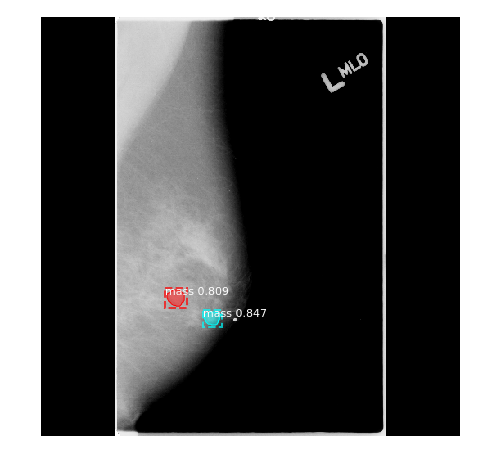

In [86]:
results = model.detect([original_image], verbose=1)
r = results[0]

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [42]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 50)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    print(image_id)
#     log("image", image)
#     log("mask", gt_mask)
#     log("class_ids", gt_class_id)
#     log("bbox", gt_bbox)
#     # Display image and instances
#     visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, dataset_val.class_names)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

50
111
145
183


ValueError: cannot reshape array of size 0 into shape (0)

In [3]:
!rm -r /data1/share/shiky/Mask_RCNN/data/logs/*

rm: cannot remove '/data1/share/shiky/Mask_RCNN/data/logs/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0023.h5': No such file or directory


In [3]:
!ls /data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/*

/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0001.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0002.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0003.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0004.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0005.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0006.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0007.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0008.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0009.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0010.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0011.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0012.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcn